# Audio Transform Experiments

# Imports

In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import numpy as np
import random 
import os
import matplotlib.pyplot as plt
import math

In [2]:
np.set_printoptions(threshold=np.inf, suppress=True)

# Extracting Audio info

In [3]:
# Params

FRAME_RATE = 24
HOP_WINDOW = 512

## Extraction functions

In [4]:
def get_audio_params(audio_path, frame_rate=FRAME_RATE, hop_window=HOP_WINDOW):
    # Load song with 22050 sample rate
    y, sr = librosa.load(audio_path, sr=22050)
    audio_duration = librosa.get_duration(y, sr=sr)
    
    total_frames_float = audio_duration * frame_rate
    total_frames = math.ceil(total_frames_float)
    
    sample_rate = round(total_frames_float / audio_duration * hop_window)
    
    return total_frames, sample_rate, audio_duration

In [5]:
def get_onset_info(audio_path, sample_rate, frame_rate=FRAME_RATE, hop_window=HOP_WINDOW):
    # Load
    y, sr = librosa.load(audio_path, sr=sample_rate)
    
    # Onset strengths and normalize
    onset_strengths = librosa.onset.onset_strength(y=y, sr=sample_rate, aggregate=np.median)
    onset_strengths = librosa.util.normalize(onset_strengths)
    
    # Onset timestamps and frames
    onset_times = librosa.times_like(onset_strengths, sr=sample_rate)
    onset_frames = onset_times * frame_rate
    
    onset_info = np.concatenate([
        onset_frames.reshape((-1, 1)),
        onset_times.reshape((-1, 1)),
        onset_strengths.reshape((-1, 1))
    ], axis=1)
    
    # Beat times
    beat_times = librosa.beat.beat_track(y=y, sr=sample_rate, units='time')[1]
    
    return y, onset_info, beat_times

In [6]:
total_frames, sample_rate, audio_duration = get_audio_params('Drums.wav', frame_rate=FRAME_RATE, hop_window=HOP_WINDOW)
total_frames, sample_rate, audio_duration

(201, 12288, 8.347845804988662)

In [7]:
y, onset_info, beat_times = get_onset_info('Drums.wav', sample_rate, frame_rate=FRAME_RATE, hop_window=HOP_WINDOW)
y.shape, onset_info.shape, beat_times.shape

/home/lscr/.pyenv/versions/3.10.6/envs/wagon-ta/lib/python3.10/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


((102579,), (201, 3), (14,))

In [8]:
onset_info

array([[  0.        ,   0.        ,   0.        ],
       [  1.        ,   0.04166667,   0.        ],
       [  2.        ,   0.08333333,   0.        ],
       [  3.        ,   0.125     ,   0.        ],
       [  4.        ,   0.16666667,   0.        ],
       [  5.        ,   0.20833333,   0.        ],
       [  6.        ,   0.25      ,   0.        ],
       [  7.        ,   0.29166667,   0.        ],
       [  8.        ,   0.33333333,   0.        ],
       [  9.        ,   0.375     ,   0.        ],
       [ 10.        ,   0.41666667,   0.        ],
       [ 11.        ,   0.45833333,   0.        ],
       [ 12.        ,   0.5       ,   0.35678828],
       [ 13.        ,   0.54166667,   0.        ],
       [ 14.        ,   0.58333333,   0.        ],
       [ 15.        ,   0.625     ,   0.47240004],
       [ 16.        ,   0.66666667,   0.01160823],
       [ 17.        ,   0.70833333,   0.        ],
       [ 18.        ,   0.75      ,   0.        ],
       [ 19.        ,   0.79166

In [9]:
beat_times

array([0.625     , 1.16666667, 1.66666667, 2.16666667, 2.66666667,
       3.20833333, 3.75      , 4.25      , 4.79166667, 5.33333333,
       5.83333333, 6.33333333, 6.875     , 7.375     ])

In [10]:
# onset_info

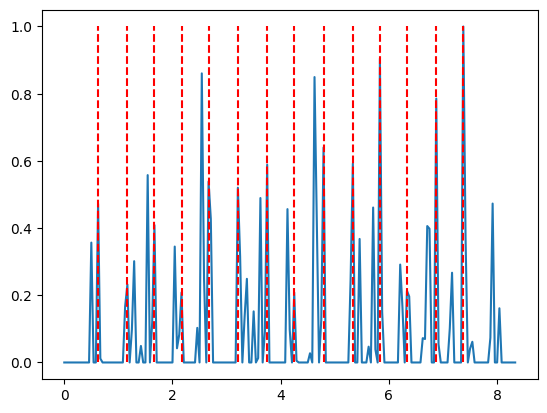

In [11]:
plt.plot(onset_info[:,1], onset_info[:,2])
plt.vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')
plt.show()

## Create additional onset strength features

- Linear Decay
- Exponential Decay

In [12]:
def create_onset_features(onset_info, beat_times, fixed_decay_frames=20, exp_decay_rate=0.2, decay_magnification=False):
    
    # Create column of zeroes as default value for both Linear and Exp Decay
    onset_info = np.concatenate([onset_info, np.zeros((onset_info.shape[0], 1)), np.zeros((onset_info.shape[0], 1))], axis=1)
    
    # for each row
    for i in range(onset_info.shape[0]):
        # Skip the first value, makes life easy
        if i == 0:
            onset_info[i, 3] = 0
        
        
        ## LINEAR
        # If the timestamp is in beat_times, it's a peak
        if onset_info[i, 1] in beat_times:
            onset_info[i, 3] = onset_info[i, 2] # Linear Column
            
            # Decay Params
            decay_factor = 1
            if decay_magnification:
                decay_factor *= (onset_info[i, 2] + 1)
            
            decay_frames = fixed_decay_frames * decay_factor
            lin_decay_val = onset_info[i, 2] / decay_frames
        
        # Check if the previous value is zero or less than the decay_val -> 0
        if onset_info[i - 1, 3] == 0. or abs(onset_info[i -1, 3]) < lin_decay_val:
            pass
        
        # If previous value > 0, needs decay
        elif onset_info[i - 1, 3] > 0: 
            onset_info[i, 3] = onset_info[i - 1, 3] - lin_decay_val
        
        
        # EXPONENTIAL
        # If the timestamp is in beat_times, it's a peak
        if onset_info[i, 1] in beat_times:
            onset_info[i, 4] = onset_info[i, 2] # Exp Column
        
        # Set current to zero if previous is zero or small number
        elif onset_info[i - 1, 4] == 0 or onset_info[i - 1, 4] < 0.005: 
            pass
        
        # If previous value > 0, needs decay
        elif onset_info[i - 1, 4] != 0: 
                onset_info[i, 4] = onset_info[i - 1, 4] * (1 - exp_decay_rate)
    
    return onset_info

In [26]:
y, onset_info, beat_times = get_onset_info('Drums.wav', sample_rate, frame_rate=FRAME_RATE, hop_window=HOP_WINDOW)
onset_info = create_onset_features(onset_info, beat_times, fixed_decay_frames=20, exp_decay_rate=0.15, decay_magnification=False)

/home/lscr/.pyenv/versions/3.10.6/envs/wagon-ta/lib/python3.10/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


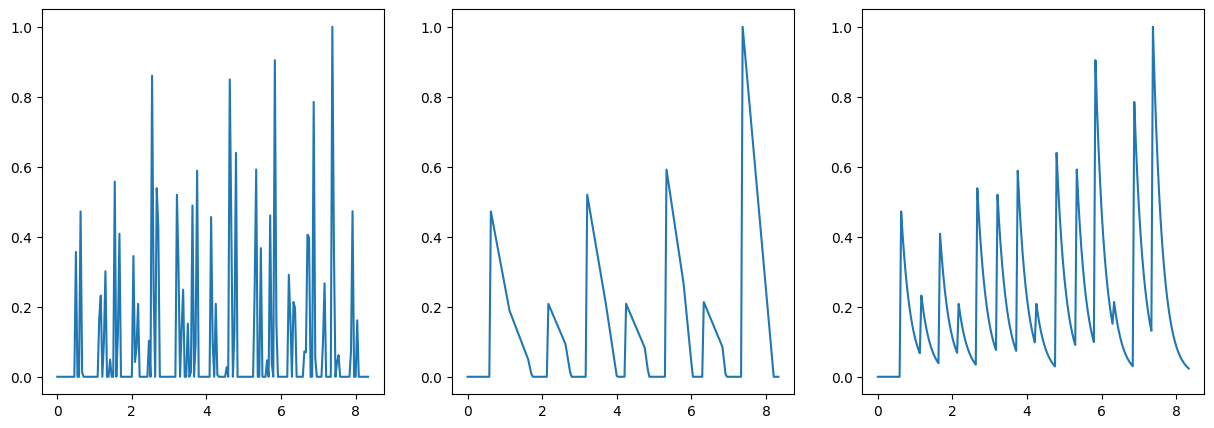

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3)

fig.set_figheight(5)
fig.set_figwidth(15)

ax[0].plot(onset_info[:,1], onset_info[:,2])
# ax[0].vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')
ax[1].plot(onset_info[:,1], onset_info[:,3])
# ax[1].vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')
ax[2].plot(onset_info[:,1], onset_info[:,4])
# ax[2].vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')

plt.show()

# Model Stuff

In [15]:
import numpy as np
from PIL import Image
import os

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, Dense, Flatten, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory

2023-03-14 21:17:44.607186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 21:17:44.690196: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-14 21:17:44.693283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 21:17:44.693290: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [16]:
ds = image_dataset_from_directory('../raw_data/zelle', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2360 files belonging to 1 classes.


2023-03-14 21:17:45.711332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 21:17:45.711357: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 21:17:45.711374: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lscr): /proc/driver/nvidia/version does not exist
2023-03-14 21:17:45.711622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
ds = ds.map(lambda x: x/255)

In [18]:
imgs = ds.as_numpy_iterator().__next__()
imgs.shape

(16, 448, 448, 3)

### Model Architecture

Because we are using load weights, we need to instantiate the model every time. This sucks for notebooks, but it will be fine once everything is packaged.

In [19]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [20]:
latent_dim = 200

## Encoder

input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

# Encoder Build
encoder = Model(input_image, [z_mean, z_log_var, z], name="encoder")

#############################################

## Decoder

latent_inputs = Input(shape=(latent_dim,))  
y = Dense(7*7*64, activation='tanh')(latent_inputs)
y = Reshape((7, 7, 64))(y)

y = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(y)

decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(y)

# Decoder Build
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")

In [21]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Instantiate Model and Load weights

In [22]:
vae = VAE(encoder, decoder)

vae.load_weights('../saved_models/model_vae_2500')

### Predict

In [23]:
IMAGE_TIME_GAP = 5 # seconds, play with this
IMAGE_FRAME_GAP = IMAGE_TIME_GAP * FRAME_RATE
IMAGE_FRAME_GAP

120

In [24]:
N_IMAGES = math.ceil(audio_duration / IMAGE_TIME_GAP + 1)
N_IMAGES

3

In [25]:
image_list = list(range(2200))
image_vectors = []

for _ in range(N_IMAGES):
    rand_number = image_list.pop(np.random.randint(0, len(image_list)))
    image_vectors.append(numpy_array[rand_number])

NameError: name 'numpy_array' is not defined

In [ ]:
# This would be where you would select three random latent vectors, but we don't have that yet
# I am going to select three random images from the 16 loaded, don't be me. Randomly select from all of them 

random_start_point = np.random.randint(0, 14, size=(1))[0]
random_start_point

In [ ]:
encoded_images = vae.encoder.predict(imgs[random_start_point: random_start_point + N_IMAGES])[2]

In [ ]:
encoded_images.shape

In [ ]:
decoded_images_z = vae.decoder.predict(encoded_images)

In [ ]:
encoded_images.shape

# Create Interpolated Images

In [ ]:
300 // IMAGE_FRAME_GAP

In [ ]:
total_frames

In [ ]:
# Find step vecs between each image

def create_step_vecs(N_IMAGES, IMAGE_FRAME_GAP, encoded_images):
    step_vecs = []
    for i in range(N_IMAGES - 1):
        step_vecs.append((encoded_images[i] - encoded_images[i + 1]) / IMAGE_FRAME_GAP)
    return step_vecs

In [ ]:
step_vecs = create_step_vecs(N_IMAGES, IMAGE_FRAME_GAP, encoded_images)

In [ ]:
step_vecs[1].shape

In [ ]:
def create_interpolation_vectors(encoded_images, onset_info, ):

In [ ]:
##################### UNFINISHED
def create_interpolation_vectors(encoded_images, step_vecs, onset_info):
    interp_vectors = []
    
    for i in range(total_frames):
        image_segment_number = i // IMAGE_FRAME_GAP

    return np.array(interp_vectors)
#################### UNFINISHED

# Spleeter Testing

I have no idea how this works, just use `Separator.separate_to_file`

In [ ]:
from spleeter.separator import Separator

In [ ]:
seperator = Separator(params_descriptor='spleeter:4stems')

In [ ]:
total_frames, sample_rate, audio_duration = get_audio_params('choice.wav', frame_rate=FRAME_RATE, hop_window=HOP_WINDOW)
total_frames, sample_rate, audio_duration

In [ ]:
y, onset_info, beat_times = get_onset_info('choice.wav', sample_rate, frame_rate=FRAME_RATE, hop_window=HOP_WINDOW)

In [ ]:
y, sr = librosa.load('choice.wav', sr=22050, mono=True)
y.reshape((-1, 1)).shape

In [ ]:
stems = seperator.separate(y.reshape((-1, 1)), audio_descriptor='test')

In [ ]:
stems.keys()

In [ ]:
stems['drums'][:50]

In [ ]:
import soundfile as sf
from IPython.display import Audio

In [ ]:
test_data = stems['drums'][:,1].reshape(-1)
# test_data

In [ ]:
Audio(data=test_data, rate=sr)

In [ ]:
Audio(data=y, rate=sample_rate)

In [ ]:
drums, sr = librosa.load('../raw_data/split_audio/choice/drums.wav', sr=sample_rate)

In [ ]:
Audio(data=drums, rate=sample_rate)